In [2]:
import numpy as np
from matplotlib import pyplot as plt
from glob import glob
from tqdm.notebook import tqdm
import librosa

plt.rcParams["font.sans-serif"] = ["SimHei"]  # 设置字体
plt.rcParams["axes.unicode_minus"] = False    # 该语句解决图像中的"-"负号的乱码问题

In [3]:
# Audio类
class Audio:
    def __init__(self, type, num, wav_durations):
        self.type = type
        self.num = num
        self.wav_durations = wav_durations

In [4]:
# 语音根路径
audio_path = r"D:\Users\GraduationDesign\AudioProcessed\*" 

path_list = np.array(glob(audio_path))
languages = np.empty_like(path_list)

i = 0
for lang in path_list:
    languages[i] = lang.split('\\')[4]
    i+=1

print(languages)


['Hangzhou' 'Henan' 'Minnan' 'Shanghai' 'Sichuan' 'Suzhou' 'Yueyu']


In [5]:
wav_num = {}
for type in languages:
    full_path = audio_path[:-1] + type + r"\*"
    wav_num[type] = len(glob(full_path))

wav_num

{'Hangzhou': 17584,
 'Henan': 27492,
 'Minnan': 25521,
 'Shanghai': 26848,
 'Sichuan': 27909,
 'Suzhou': 18754,
 'Yueyu': 23945}

In [6]:
# 建立Audio对象集合
import time
import functools
from concurrent.futures import ThreadPoolExecutor

executer = ThreadPoolExecutor(max_workers=None) # 默认最大=cpu_count*5
wav_load = functools.partial(librosa.load, sr=None)


audios = []
total_durations = np.zeros(len(languages))

# 开始时间
localtime = time.localtime()
print('%s-%s-%s %02s:%02s:%02s'%(localtime.tm_year,localtime.tm_mon, localtime.tm_mday, localtime.tm_hour, localtime.tm_min, localtime.tm_sec))

for i in tqdm(iterable=range(len(languages)),
              total=len(languages),
              desc="Total",
              position=0):
    type = languages[i]
    path = audio_path[:-1] + type + r"\*"
    paths = glob(path)
    num = len(paths)
    duration_list = np.zeros(num, dtype='float')
    sum = np.float32(0)
    
    for j in tqdm(iterable=range(num),
                  total=num,
                  desc=type,
                  position=1):
        future = executer.submit(fn=wav_load, path=paths[j])
        wav, sr = future.result()
        # wav, sr = wav_load(path=paths[j])
        duration = np.float32(0)
        duration = librosa.get_duration(y=wav, sr=sr)
        duration_list[j] = duration
        sum += duration
        
    audio = Audio(type, num, duration_list)
    audios.append(audio)
    total_durations[i] = sum

print(total_durations)

2023-3-10 11:9:35


Total:   0%|          | 0/7 [00:00<?, ?it/s]

Hangzhou:   0%|          | 0/17584 [00:00<?, ?it/s]

Henan:   0%|          | 0/27492 [00:00<?, ?it/s]

Minnan:   0%|          | 0/25521 [00:00<?, ?it/s]

Shanghai:   0%|          | 0/26848 [00:00<?, ?it/s]

Sichuan:   0%|          | 0/27909 [00:00<?, ?it/s]

Suzhou:   0%|          | 0/18754 [00:00<?, ?it/s]

Yueyu:   0%|          | 0/23945 [00:00<?, ?it/s]

[44355.63 79688.58 72085.65 63290.88 81168.42 42259.41 80149.08]


In [ ]:

import functools
wav_load = functools.partial(librosa.load, sr=None)

audios = []
total_durations = np.zeros(len(languages))


for i in tqdm(iterable=range(len(languages)),
              total=len(languages),
              desc="Total",
              position=0):
    type = languages[i]
    path = audio_path[:-1] + type + r"\*"
    paths = glob(path)
    num = len(paths)
    duration_list = np.zeros(num, dtype='float')
    sum = np.float32(0)
    
    for j in tqdm(iterable=range(num),
                  total=num,
                  desc=type,
                  position=1):
        future = executer.submit(fn=wav_load, path=paths[j])
        wav, sr = future.result()
        # wav, sr = wav_load(path=paths[j])
        duration = np.float32(0)
        duration = librosa.get_duration(y=wav, sr=sr)
        duration_list[j] = duration
        sum += duration
    audio = Audio(type, num, duration_list)
    audios.append(audio)
    total_durations[i] = sum
    
print(total_durations)

2023

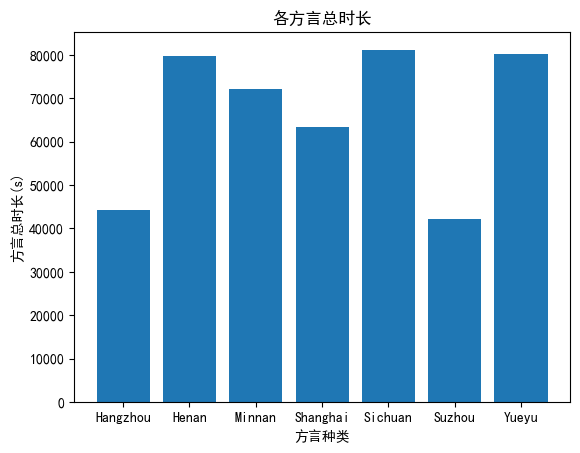

In [27]:
plt.figure("total_durations")
plt.title('各方言总时长')
plt.bar(languages, total_durations)
plt.xlabel('方言种类')
plt.ylabel("方言总时长(s)")

plt.savefig("各方言总时长.png")
plt.show()

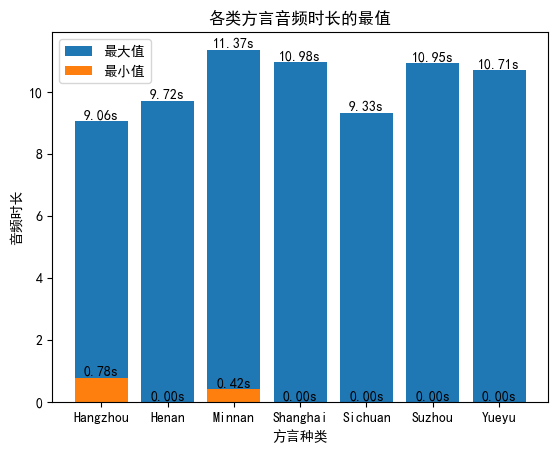

In [28]:
# 每组方言中音频的最大最小时长

maximums = np.zeros(len(languages))
minimums = np.zeros(len(languages))
i = 0
for audio in audios:
    maximums[i] = np.max(audio.wav_durations)
    minimums[i] = np.min(audio.wav_durations)
    i+=1

plt.figure("max_min_durations")
plt.title("各类方言音频时长的最值")
p1 = plt.bar(languages, maximums)
p2 = plt.bar(languages, minimums)
plt.bar_label(p1, label_type='edge', fmt="%.2fs")
plt.bar_label(p2, label_type='edge', fmt="%.2fs")

plt.legend(["最大值", "最小值"])
plt.xlabel("方言种类")
plt.ylabel("音频时长")

plt.savefig("各类方言音频时长的最值.png")
plt.show()


### 0s数据包括：
- 源音频含糊,导致当成噪音被清除
- 源音频没念完就掐断了，本身短+含糊

In [29]:
path = r"D:\Users\GraduationDesign\AudioProcessed\Sichuan\T0046G2408S0065.wav"
w, s = librosa.load(path, sr=None)
librosa.get_duration(y=w, sr=s)


0.0

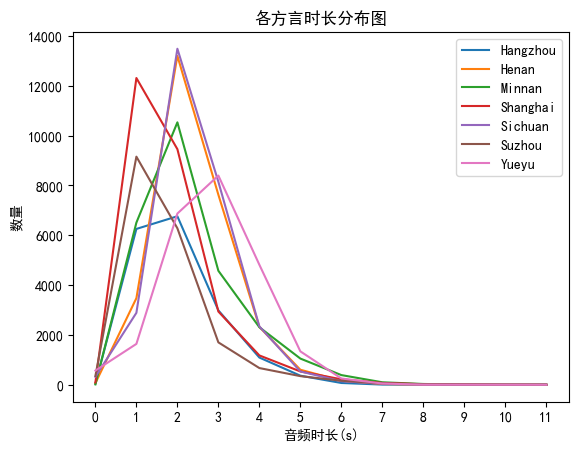

In [30]:
_min = np.floor(np.min(minimums)).astype(np.int16)
_max = np.ceil(np.max(maximums)).astype(np.int16)

plt.figure("data_distribution")
plt.title("各方言时长分布图")

for audio in audios:
    distri = np.zeros(_max-_min)
    dur = audio.wav_durations
    for i in range(_min, _max):
        distri[i-_min] = len(dur[np.multiply(dur>=i, dur<i+1)])
    plt.plot(range(_max-_min), distri)

plt.xlabel("音频时长(s)")
plt.ylabel("数量")
plt.xticks(range(_max-_min))
plt.legend(languages)

plt.savefig("各方言时长分布图.png")
plt.show()

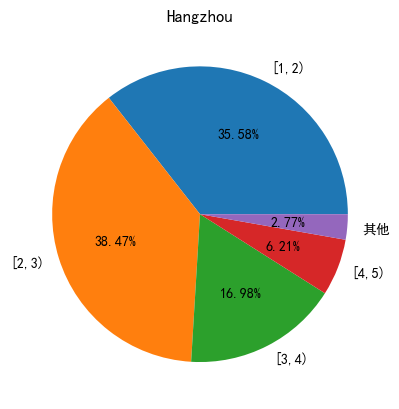

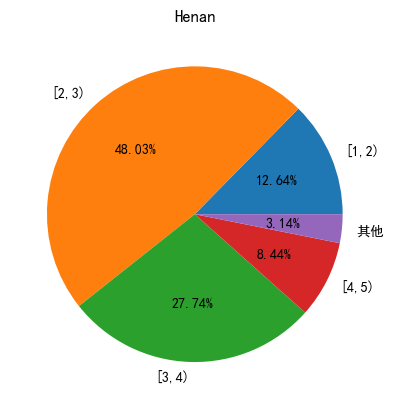

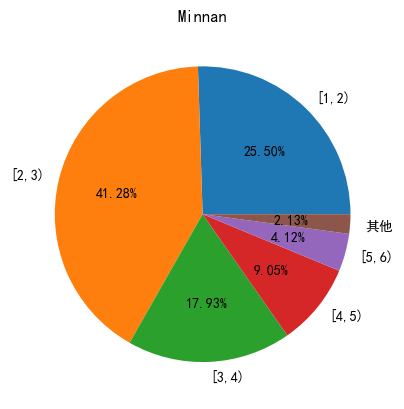

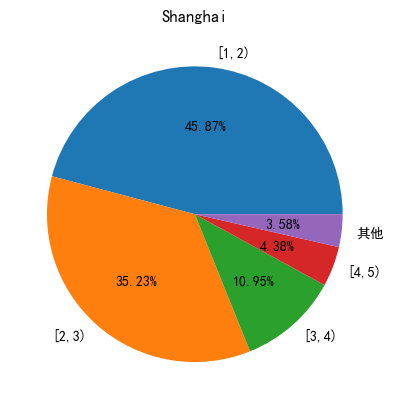

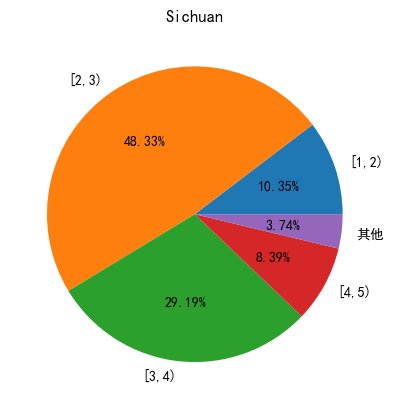

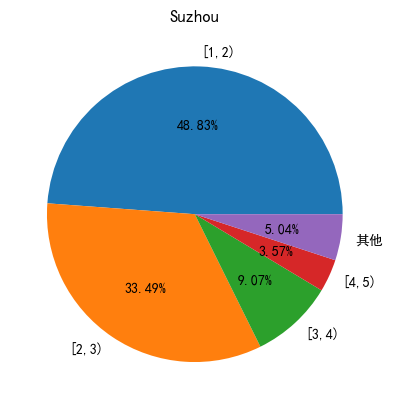

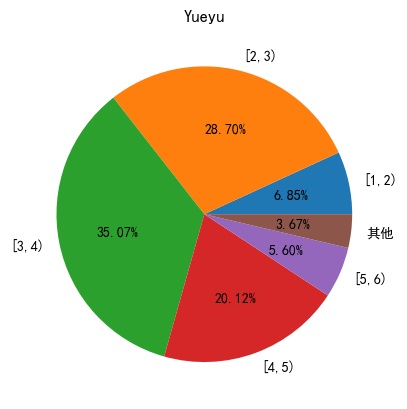

In [36]:
# 各方言中时长各时段占比

for audio in audios:
    plt.figure("proportion")
    plt.title(audio.type)
    dur = audio.wav_durations
    sum = np.sum(audio.wav_durations)
    label = []
    frac = []
    res = 0
    for i in range(_min, _max):
        prop = len(dur[np.multiply(dur>=i, dur<i+1)]) / sum
        if prop <= 0.01:
            res += prop
            continue
        frac.append(prop)
        label.append("[" + str(i) + "," + str(i+1) + ")")
    frac.append(res)
    label.append("其他")
    patches, texts, autotexts = plt.pie(frac, labels=label, autopct="%.2f%%")
    
    plt.savefig(audio.type + "方言时长占比.png")
    plt.show()

In [ ]:
wav1, sr1 = librosa.load("1.wav", sr=None)
wav2, sr2 = librosa.load("2.wav", sr=None)
# wav3, sr3 = librosa.load("3.wav", sr=None)


plt.figure(figsize=(20,15))
plt.subplot(2,1,1)
librosa.display.waveshow(wav1, sr=sr1)
plt.xticks(np.arange(0, len(wav1)/sr1 + 1, 0.5))
plt.subplot(2,1,2)
librosa.display.waveshow(wav2, sr=sr2)
plt.xticks(np.arange(0, len(wav1)/sr1 + 1, 0.5))

plt.show()

In [ ]:
# 波形图

plt.figure(figsize=(20,15))
plt.subplot(2,1,1)
librosa.display.waveshow(y=wav1, sr=sr1)
plt.xticks(np.arange(0, len(wav1)/sr1 + 1, 0.5))
plt.subplot(2,1,2)
librosa.display.waveshow(y=wav2, sr=sr2)
plt.xticks(np.arange(0, len(wav1)/sr1 + 1, 0.5))

plt.show()


In [ ]:
# Mel频谱

plt.title('Mel-scale Frequency Cepstral Coefficients')
mfcc = librosa.feature.mfcc(y=wav1, sr=sr1)
print("梅尔")
print(mfcc.shape)
librosa.display.specshow(mfcc, x_axis='time', y_axis='hz')

plt.show()

plt.title('Mel-scale Frequency Cepstral Coefficients')
mfcc = librosa.feature.mfcc(y=wav2, sr=sr2)
print("梅尔")
print(mfcc.shape)
librosa.display.specshow(mfcc, x_axis='time', y_axis='hz')

plt.show()
